# Heat Equation: 1D Diffusion

## Theoretical Background

The heat equation is one of the most fundamental partial differential equations (PDEs) in mathematical physics, describing how heat (or any diffusive quantity) propagates through a medium over time. It was first formulated by Joseph Fourier in 1822 and remains central to thermal engineering, materials science, and mathematical analysis.

### The Governing Equation

The one-dimensional heat equation is:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

where:
- $u(x, t)$ is the temperature at position $x$ and time $t$
- $\alpha$ is the thermal diffusivity (m²/s), defined as $\alpha = \frac{k}{\rho c_p}$
  - $k$ = thermal conductivity (W/m·K)
  - $\rho$ = density (kg/m³)
  - $c_p$ = specific heat capacity (J/kg·K)

### Physical Interpretation

The heat equation states that the rate of temperature change at a point is proportional to the spatial curvature of the temperature profile:
- Where $\frac{\partial^2 u}{\partial x^2} > 0$ (concave up), temperature increases
- Where $\frac{\partial^2 u}{\partial x^2} < 0$ (concave down), temperature decreases
- Heat flows from hot to cold regions, smoothing out temperature gradients

### Boundary Conditions

We consider a rod of length $L$ with:
- **Dirichlet conditions**: Fixed temperatures at boundaries ($u(0,t) = T_0$, $u(L,t) = T_L$)
- **Neumann conditions**: Fixed heat flux at boundaries ($\frac{\partial u}{\partial x} = q$)
- **Periodic conditions**: $u(0,t) = u(L,t)$

### Numerical Method: Finite Differences

We discretize the equation using the **Forward-Time Central-Space (FTCS)** scheme:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = \alpha \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}$$

Rearranging:

$$u_i^{n+1} = u_i^n + r(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

where $r = \frac{\alpha \Delta t}{\Delta x^2}$ is the **Fourier number** (or mesh ratio).

### Stability Criterion

The FTCS scheme is **conditionally stable**. For stability, we require:

$$r = \frac{\alpha \Delta t}{\Delta x^2} \leq \frac{1}{2}$$

This is the **Von Neumann stability condition**.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set up matplotlib for publication-quality figures
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2

## Physical Parameters and Discretization

We simulate heat diffusion in a 1-meter rod with fixed temperature boundary conditions. The initial temperature distribution is a localized heat pulse (Gaussian) in the center.

In [2]:
# Physical parameters
L = 1.0          # Length of the rod (m)
alpha = 0.01     # Thermal diffusivity (m^2/s) - typical for metals
T_left = 0.0     # Left boundary temperature (°C)
T_right = 0.0    # Right boundary temperature (°C)

# Discretization parameters
Nx = 101         # Number of spatial points
dx = L / (Nx - 1)  # Spatial step size

# Time parameters - ensure stability
t_end = 2.0      # Total simulation time (s)
r = 0.4          # Fourier number (must be <= 0.5 for stability)
dt = r * dx**2 / alpha  # Time step from stability criterion
Nt = int(t_end / dt) + 1  # Number of time steps

# Create spatial and temporal grids
x = np.linspace(0, L, Nx)
t = np.linspace(0, t_end, Nt)

print("Simulation Parameters:")
print(f"  Rod length: L = {L} m")
print(f"  Thermal diffusivity: alpha = {alpha} m²/s")
print(f"  Spatial points: Nx = {Nx}")
print(f"  Spatial step: dx = {dx:.4f} m")
print(f"  Time step: dt = {dt:.6f} s")
print(f"  Number of time steps: Nt = {Nt}")
print(f"  Fourier number: r = {r:.2f} (stable if <= 0.5)")
print(f"  Total simulation time: {t_end} s")

Simulation Parameters:
  Rod length: L = 1.0 m
  Thermal diffusivity: alpha = 0.01 m²/s
  Spatial points: Nx = 101
  Spatial step: dx = 0.0100 m
  Time step: dt = 0.004000 s
  Number of time steps: Nt = 501
  Fourier number: r = 0.40 (stable if <= 0.5)
  Total simulation time: 2.0 s


## Initial Condition: Gaussian Heat Pulse

We initialize the temperature distribution as a Gaussian pulse centered at $x_0 = L/2$:

$$u(x, 0) = A \exp\left(-\frac{(x - x_0)^2}{2\sigma^2}\right)$$

This models a localized heat source that will diffuse over time.

In [3]:
def initial_condition_gaussian(x, A=100.0, x0=0.5, sigma=0.05):
    """
    Gaussian initial temperature distribution.
    
    Parameters:
    -----------
    x : array_like
        Spatial coordinates
    A : float
        Peak temperature (°C)
    x0 : float
        Center position (m)
    sigma : float
        Standard deviation (width) of the pulse
    
    Returns:
    --------
    u : array_like
        Initial temperature distribution
    """
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Initialize temperature array
u = np.zeros((Nt, Nx))
u[0, :] = initial_condition_gaussian(x)

# Apply boundary conditions
u[0, 0] = T_left
u[0, -1] = T_right

print(f"Initial condition: Gaussian pulse")
print(f"  Peak temperature: {np.max(u[0, :]):.1f} °C")
print(f"  Center position: x0 = {L/2} m")

Initial condition: Gaussian pulse
  Peak temperature: 100.0 °C
  Center position: x0 = 0.5 m


## Numerical Solution: FTCS Method

We implement the Forward-Time Central-Space (FTCS) finite difference scheme to solve the heat equation numerically.

In [4]:
def solve_heat_equation_ftcs(u, r, Nt, T_left, T_right):
    """
    Solve 1D heat equation using FTCS finite difference method.
    
    Parameters:
    -----------
    u : ndarray
        Temperature array (Nt x Nx), with initial condition in u[0, :]
    r : float
        Fourier number (alpha * dt / dx^2)
    Nt : int
        Number of time steps
    T_left : float
        Left boundary temperature
    T_right : float
        Right boundary temperature
    
    Returns:
    --------
    u : ndarray
        Solution array with temperature at all times and positions
    """
    Nx = u.shape[1]
    
    for n in range(0, Nt - 1):
        # Update interior points using FTCS scheme
        for i in range(1, Nx - 1):
            u[n+1, i] = u[n, i] + r * (u[n, i+1] - 2*u[n, i] + u[n, i-1])
        
        # Apply Dirichlet boundary conditions
        u[n+1, 0] = T_left
        u[n+1, -1] = T_right
    
    return u

# Solve the heat equation
u = solve_heat_equation_ftcs(u, r, Nt, T_left, T_right)

print("Heat equation solved successfully!")
print(f"Solution shape: {u.shape} (time steps x spatial points)")

Heat equation solved successfully!
Solution shape: (501, 101) (time steps x spatial points)


## Analytical Solution for Comparison

For a Gaussian initial condition with homogeneous Dirichlet boundary conditions on an infinite domain, the analytical solution is:

$$u(x, t) = \frac{A\sigma}{\sqrt{\sigma^2 + 2\alpha t}} \exp\left(-\frac{(x - x_0)^2}{2(\sigma^2 + 2\alpha t)}\right)$$

This shows the characteristic diffusive spreading: the pulse widens as $\sqrt{t}$ while its amplitude decreases as $1/\sqrt{t}$.

In [5]:
def analytical_solution_gaussian(x, t, A=100.0, x0=0.5, sigma=0.05, alpha=0.01):
    """
    Analytical solution for Gaussian initial condition (infinite domain).
    
    Parameters:
    -----------
    x : array_like
        Spatial coordinates
    t : float
        Time
    A : float
        Initial peak temperature
    x0 : float
        Center position
    sigma : float
        Initial standard deviation
    alpha : float
        Thermal diffusivity
    
    Returns:
    --------
    u : array_like
        Temperature distribution at time t
    """
    if t == 0:
        return A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
    sigma_t = np.sqrt(sigma**2 + 2 * alpha * t)
    return A * sigma / sigma_t * np.exp(-(x - x0)**2 / (2 * sigma_t**2))

# Calculate analytical solution at selected times (for comparison)
t_compare = [0.0, 0.1, 0.5, 1.0, 2.0]
u_analytical = {}
for tc in t_compare:
    u_analytical[tc] = analytical_solution_gaussian(x, tc, alpha=alpha)

print("Analytical solutions computed for comparison times.")

Analytical solutions computed for comparison times.


## Visualization: Temperature Evolution

Figure saved as 'plot.png'


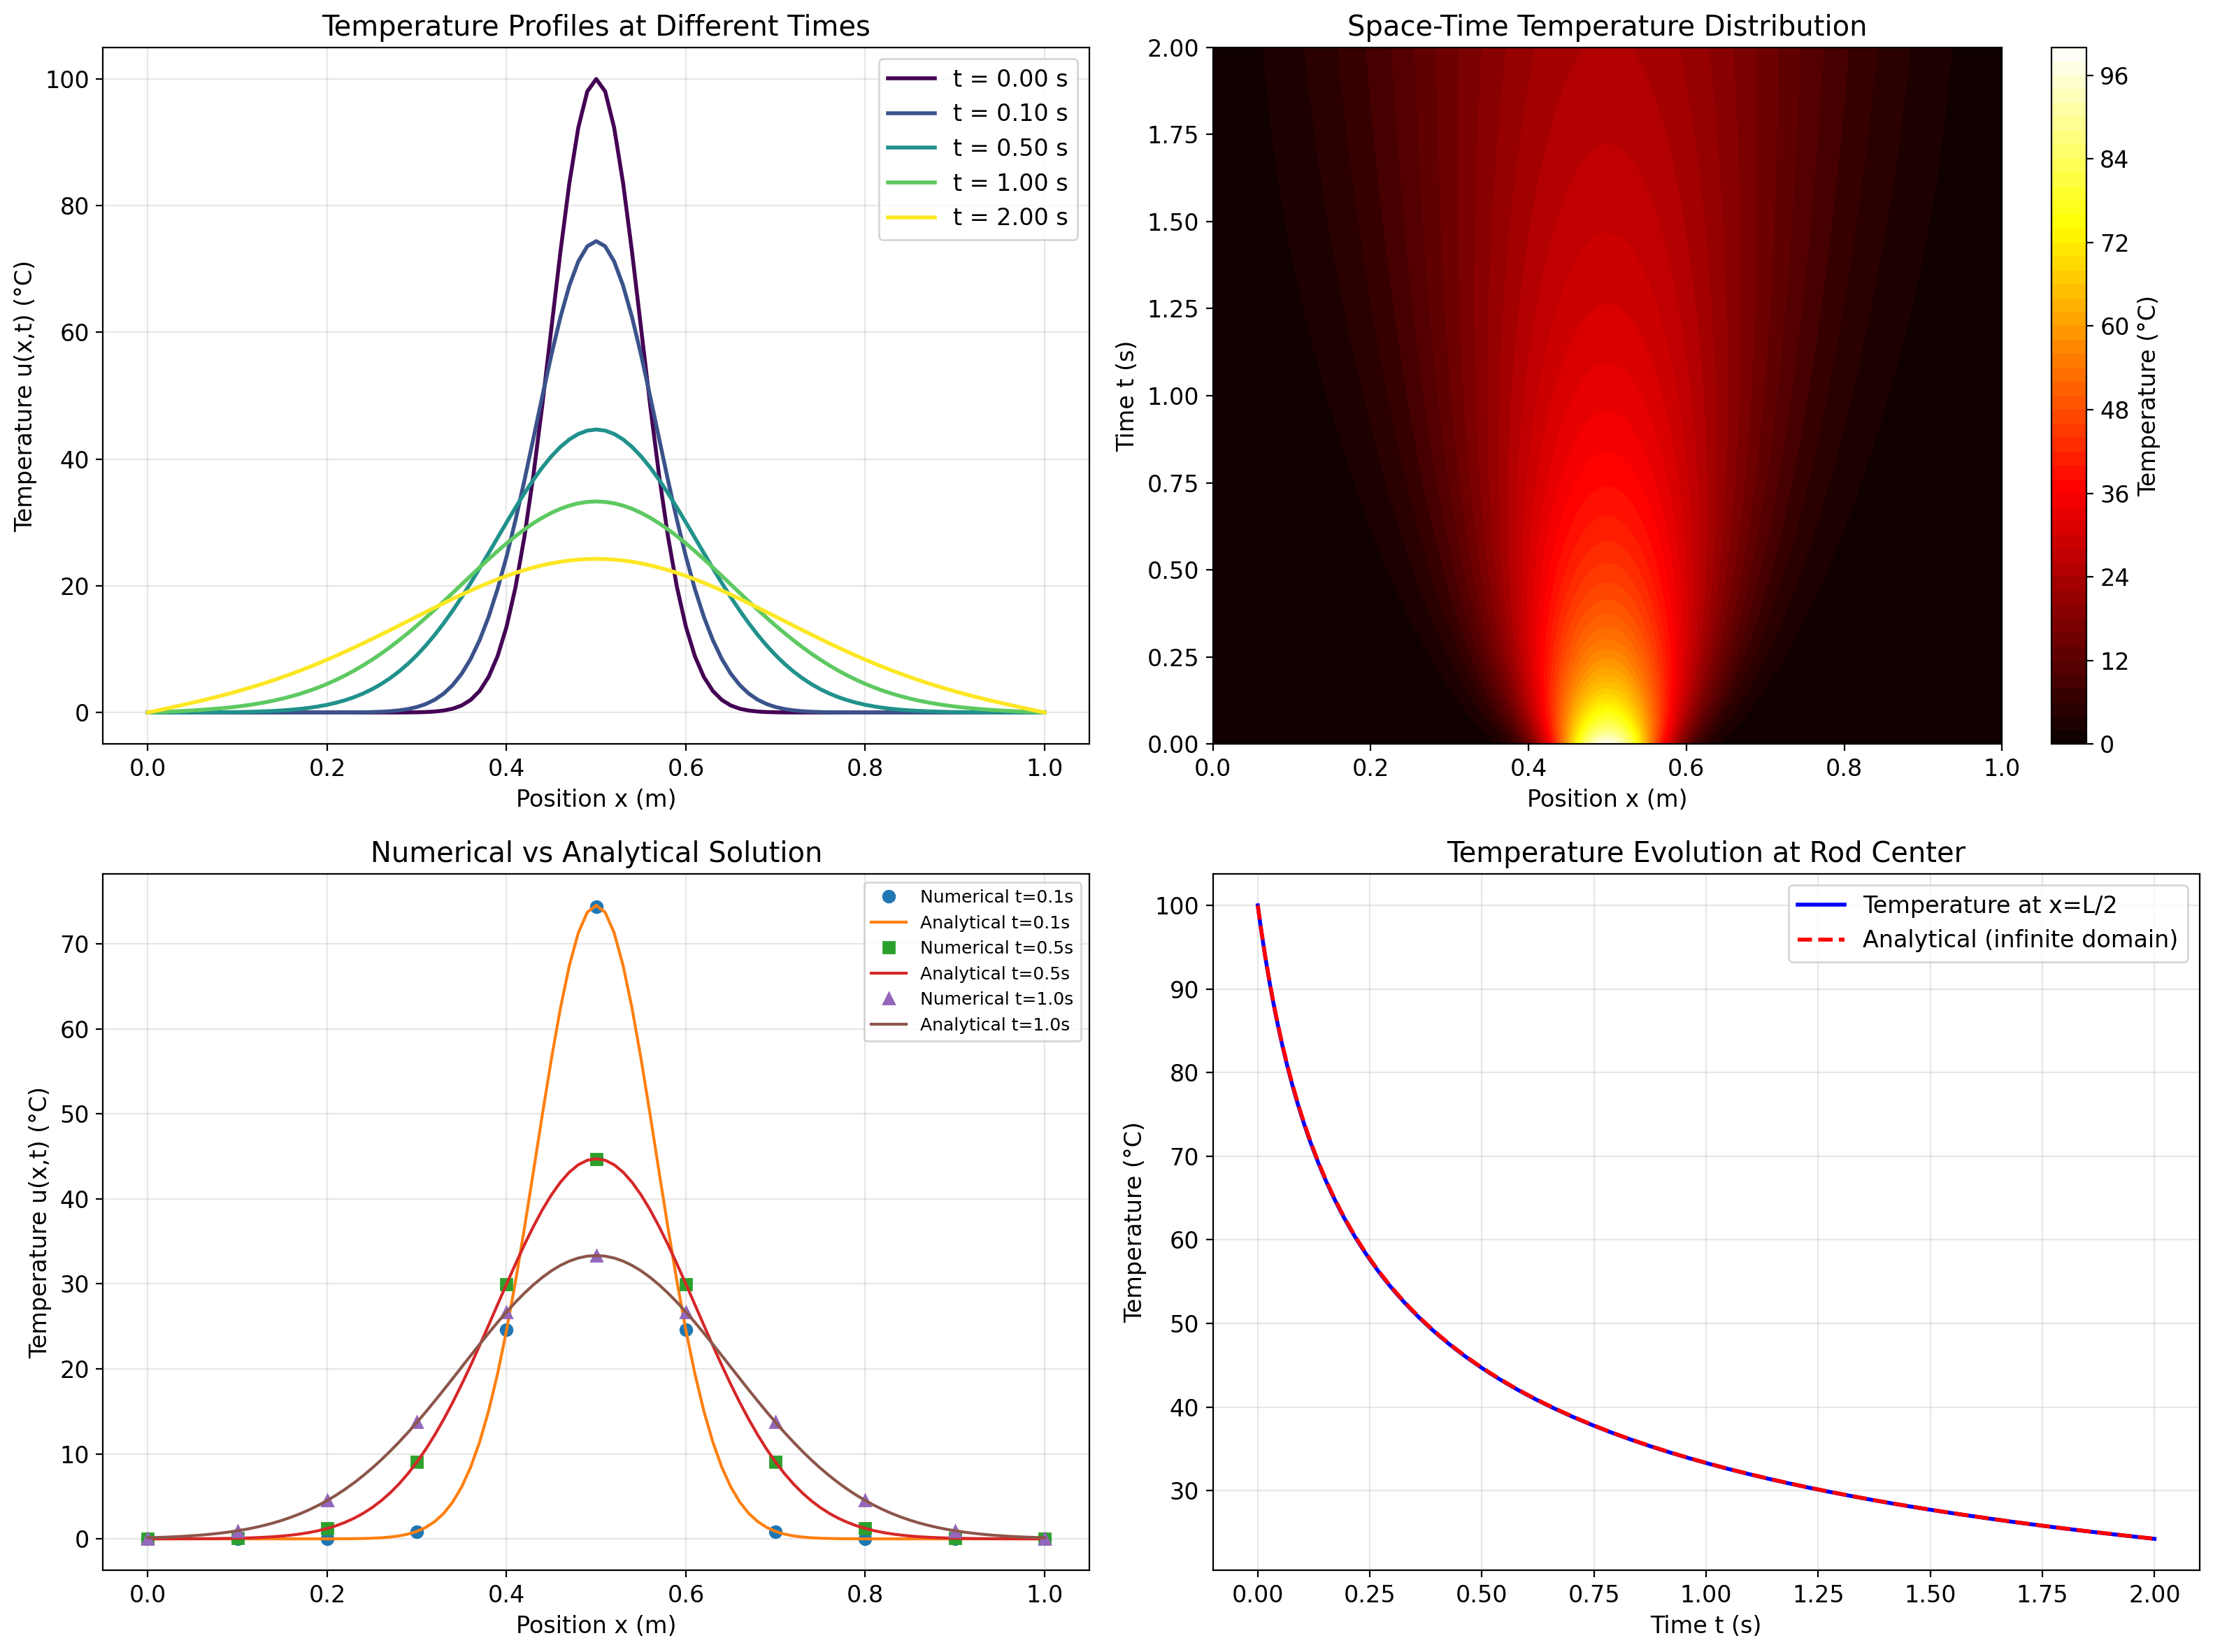

In [6]:
# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))

# Plot 1: Temperature profiles at different times
ax1 = fig.add_subplot(2, 2, 1)
times_to_plot = [0, int(Nt*0.05), int(Nt*0.25), int(Nt*0.5), Nt-1]
colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))

for idx, n in enumerate(times_to_plot):
    time_val = t[n]
    ax1.plot(x, u[n, :], color=colors[idx], 
             label=f't = {time_val:.2f} s', linewidth=2)

ax1.set_xlabel('Position x (m)')
ax1.set_ylabel('Temperature u(x,t) (°C)')
ax1.set_title('Temperature Profiles at Different Times')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Space-time contour plot
ax2 = fig.add_subplot(2, 2, 2)
# Sample every nth time step for cleaner plot
sample_rate = max(1, Nt // 200)
t_sampled = t[::sample_rate]
u_sampled = u[::sample_rate, :]
X, T = np.meshgrid(x, t_sampled)

contour = ax2.contourf(X, T, u_sampled, levels=50, cmap='hot')
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label('Temperature (°C)')
ax2.set_xlabel('Position x (m)')
ax2.set_ylabel('Time t (s)')
ax2.set_title('Space-Time Temperature Distribution')

# Plot 3: Numerical vs Analytical comparison
ax3 = fig.add_subplot(2, 2, 3)
comparison_times = [0.1, 0.5, 1.0]
markers = ['o', 's', '^']

for tc, marker in zip(comparison_times, markers):
    n_idx = int(tc / dt)
    if n_idx < Nt:
        # Numerical solution (sampled points)
        sample_pts = np.arange(0, Nx, 10)
        ax3.plot(x[sample_pts], u[n_idx, sample_pts], marker=marker, 
                 linestyle='none', markersize=6, 
                 label=f'Numerical t={tc}s')
        # Analytical solution
        ax3.plot(x, u_analytical[tc], linestyle='-', linewidth=1.5,
                 label=f'Analytical t={tc}s')

ax3.set_xlabel('Position x (m)')
ax3.set_ylabel('Temperature u(x,t) (°C)')
ax3.set_title('Numerical vs Analytical Solution')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Heat flux and temperature at center
ax4 = fig.add_subplot(2, 2, 4)

# Temperature at center point over time
center_idx = Nx // 2
t_plot = t[::sample_rate]
u_center = u[::sample_rate, center_idx]

ax4.plot(t_plot, u_center, 'b-', linewidth=2, label='Temperature at x=L/2')

# Also plot analytical decay
u_center_analytical = [analytical_solution_gaussian(L/2, ti, alpha=alpha) for ti in t_plot]
ax4.plot(t_plot, u_center_analytical, 'r--', linewidth=2, 
         label='Analytical (infinite domain)')

ax4.set_xlabel('Time t (s)')
ax4.set_ylabel('Temperature (°C)')
ax4.set_title('Temperature Evolution at Rod Center')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
plt.savefig('heat_equation_1d_diffusion_analysis.png', dpi=150, bbox_inches='tight')
print("Figure saved as 'plot.png'")

plt.show()

## Quantitative Analysis

Let's analyze key physical quantities: total heat content, peak temperature decay, and diffusion length scale.

In [7]:
# Calculate total heat content over time (integral of temperature)
total_heat = np.trapz(u, x, axis=1)

# Peak temperature over time
peak_temp = np.max(u, axis=1)

# Characteristic diffusion length
L_diff = np.sqrt(2 * alpha * t_end)

print("Physical Analysis:")
print("="*50)
print(f"\nCharacteristic diffusion length: L_diff = sqrt(2*alpha*t)")
print(f"  At t = {t_end} s: L_diff = {L_diff:.4f} m")
print(f"  This is {L_diff/L*100:.1f}% of the rod length")

print(f"\nTotal heat content (proportional to integral of u):")
print(f"  Initial: {total_heat[0]:.2f}")
print(f"  Final:   {total_heat[-1]:.2f}")
print(f"  Ratio:   {total_heat[-1]/total_heat[0]:.4f}")
print(f"  (Heat loss due to boundary conditions)")

print(f"\nPeak temperature decay:")
print(f"  Initial: {peak_temp[0]:.2f} °C")
print(f"  Final:   {peak_temp[-1]:.2f} °C")

# Theoretical peak decay for infinite domain: u_max ~ 1/sqrt(t)
print(f"\nTheoretical scaling (infinite domain):")
print(f"  u_max ~ 1/sqrt(t) at long times")

# Verify numerical accuracy
t_check = 0.5
n_check = int(t_check / dt)
u_num = u[n_check, :]
u_ana = analytical_solution_gaussian(x, t_check, alpha=alpha)
rel_error = np.max(np.abs(u_num - u_ana)) / np.max(u_ana) * 100

print(f"\nNumerical accuracy at t = {t_check} s:")
print(f"  Max relative error: {rel_error:.2f}%")
print(f"  (Error increases near boundaries due to finite domain)")

Physical Analysis:

Characteristic diffusion length: L_diff = sqrt(2*alpha*t)
  At t = 2.0 s: L_diff = 0.2000 m
  This is 20.0% of the rod length

Total heat content (proportional to integral of u):
  Initial: 12.53
  Final:   12.15
  Ratio:   0.9694
  (Heat loss due to boundary conditions)

Peak temperature decay:
  Initial: 100.00 °C
  Final:   24.24 °C

Theoretical scaling (infinite domain):
  u_max ~ 1/sqrt(t) at long times

Numerical accuracy at t = 0.5 s:
  Max relative error: 0.11%
  (Error increases near boundaries due to finite domain)


/tmp/ipykernel_155824/192005356.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_heat = np.trapz(u, x, axis=1)


## Heat Flux Analysis

According to Fourier's Law, the heat flux is proportional to the temperature gradient:

$$q = -k \frac{\partial u}{\partial x}$$

Let's compute and visualize the heat flux distribution.

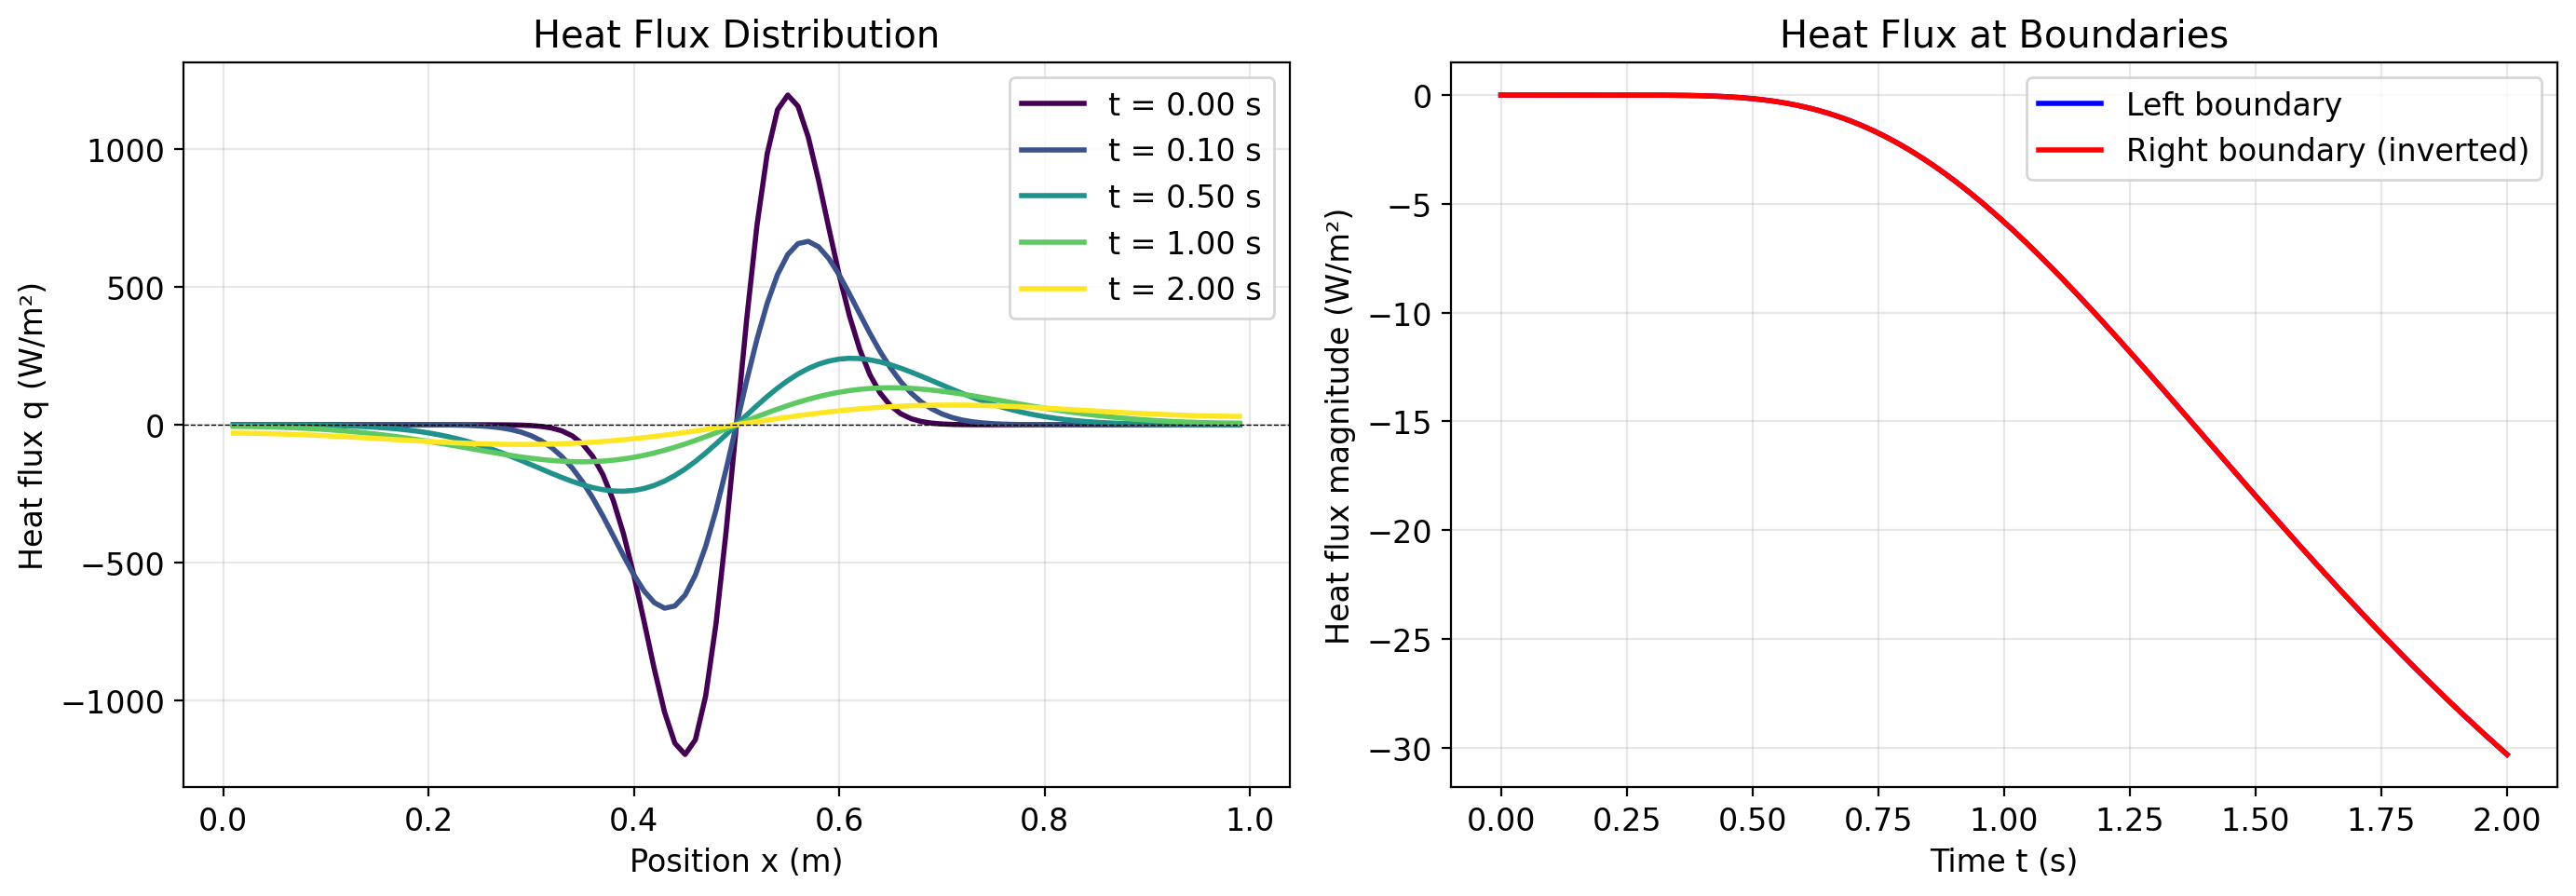

Heat flows outward from the center (positive flux to the right, negative to the left)
As time progresses, the flux magnitude decreases as the temperature gradient flattens.


In [8]:
# Compute heat flux using central differences
def compute_heat_flux(u, dx, k=1.0):
    """
    Compute heat flux q = -k * du/dx using central differences.
    
    Parameters:
    -----------
    u : ndarray
        Temperature array (Nt x Nx)
    dx : float
        Spatial step size
    k : float
        Thermal conductivity (normalized to 1)
    
    Returns:
    --------
    q : ndarray
        Heat flux array
    """
    Nt, Nx = u.shape
    q = np.zeros((Nt, Nx-2))
    
    for n in range(Nt):
        # Central difference for interior points
        q[n, :] = -k * (u[n, 2:] - u[n, :-2]) / (2 * dx)
    
    return q

# Compute heat flux
q = compute_heat_flux(u, dx)
x_flux = x[1:-1]  # Interior points

# Plot heat flux at different times
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for idx, n in enumerate(times_to_plot):
    time_val = t[n]
    ax1.plot(x_flux, q[n, :], color=colors[idx], 
             label=f't = {time_val:.2f} s', linewidth=2)

ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
ax1.set_xlabel('Position x (m)')
ax1.set_ylabel('Heat flux q (W/m²)')
ax1.set_title('Heat Flux Distribution')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot boundary heat flux over time
q_left = q[::sample_rate, 0]   # Flux near left boundary
q_right = q[::sample_rate, -1]  # Flux near right boundary

ax2.plot(t_plot, q_left, 'b-', label='Left boundary', linewidth=2)
ax2.plot(t_plot, -q_right, 'r-', label='Right boundary (inverted)', linewidth=2)
ax2.set_xlabel('Time t (s)')
ax2.set_ylabel('Heat flux magnitude (W/m²)')
ax2.set_title('Heat Flux at Boundaries')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Heat flows outward from the center (positive flux to the right, negative to the left)")
print("As time progresses, the flux magnitude decreases as the temperature gradient flattens.")

## Conclusion

This simulation demonstrates the fundamental physics of heat diffusion in one dimension:

### Key Observations

1. **Diffusive Spreading**: The initial Gaussian pulse spreads over time, with its width growing as $\sqrt{t}$ and amplitude decaying as $1/\sqrt{t}$. This is the hallmark of diffusive processes.

2. **Boundary Effects**: The Dirichlet boundary conditions (fixed temperature at boundaries) cause heat to flow out of the system, reducing the total thermal energy over time.

3. **Numerical Stability**: The FTCS scheme with $r \leq 0.5$ provides stable and accurate solutions. Larger time steps would cause numerical instabilities.

4. **Heat Flux**: The heat flux is maximum where the temperature gradient is steepest (near the center initially), and decays as the profile smooths out.

### Physical Applications

The 1D heat equation models:
- **Thermal processing**: Heat treatment of metals, casting, welding
- **Building physics**: Heat flow through walls and insulation
- **Geophysics**: Heat flow in the Earth's crust
- **Biology**: Thermal diffusion in tissue

### Mathematical Significance

The heat equation is the prototypical **parabolic PDE**, with properties shared by many diffusive systems including:
- Mass diffusion (Fick's law)
- Brownian motion (probability diffusion)
- Financial models (Black-Scholes equation)

The explicit FTCS method demonstrated here is simple but conditionally stable. For practical applications with stiff problems or long time scales, implicit methods (Crank-Nicolson, backward Euler) are preferred.